# Simulation working normally

In [62]:
import tqdm
import bokeh
import numpy as np

# Column 0 is change in m, column 1 is change in p
simple_update = np.array([[1, 0, 0, 0],    # Make Healthy mRNA transcript
                        [0, 1, 0, 0],      # Make Damaged mRNA transcript
                        [-1, 0, 0, 0],     # Degrade Healthy mRNA transcript
                        [0, -1, 0, 0],     # Degrade Damaged mRNA transcript
                        [0, 0, 1, 0],      # Accumulate damage on gene
                        [0, 0, -1, 0],     # Repair Damage on gene
                        [0, 1, 0, 0],      # Do not detect damage and make damaged transcript
                        [0, 0, 0, 1],      # Gene turns on
                        [0, 0, 0, -1]      # Gene turns off
                        ], 
                        dtype=int)
                        
def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1 # This is returning the reaction event that will occur

def simple_propensity(propensities, population, t, beta_m, gamma_m, u, Pd, gene_on, gene_off):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    m_healthy = population[0] # number of healthy mRNAs
    m_damaged = population[1] # number of damaged mRNAs
    d = population[2]         # number of damage sites
    G_state = population[3]   # 1 or 0 for gene being ON or OFF

    # Update propensities
    # these events rely on the gene being ON or OFF
    if G_state == 1:  # Gene is ON  
        # Update propensities
        if d == 0: # Gene is ON and has no damage

            propensities[0] = beta_m      # Make healthy mRNA transcript at rate beta_m if no damage on gene
            propensities[1] = 0           # Probability of Make damaged mRNA
            
            propensities[2] = m_healthy * gamma_m # Degrade healthy mRNA
            propensities[3] = m_damaged * gamma_m # Degrade damaged mRNA
            propensities[4] = u           # Add a damage site to the gene
            propensities[5] = 0 # Detect damage site and repair
            propensities[6] = 0 # Do not detect damage site and transcribe mRNA (with error in it)
        
        else: # Gene is ON and has damage 

            propensities[0] = 0      # if there is damage on DNA, probability of making healthy mRNA = 0
            propensities[1] = 0      # Make damaged mRNA

            propensities[2] = m_healthy * gamma_m # Degrade healthy mRNA
            propensities[3] = m_damaged * gamma_m # Degrade damaged mRNA

            propensities[4] = u           # Add a damage site to the gene
            propensities[5] = beta_m * ((1-(1-Pd)**d)) # Detect damage site and repair
            propensities[6] = beta_m * ((1-Pd)**d) # Do not detect damage site and transcribe mRNA (with error in it)

    else: # Gene is OFF (damage is irrelevant here)
        propensities[0] = 0 # no healthy mRNA production
        propensities[1] = 0 # no damaged mRNA production
        propensities[2] = m_healthy * gamma_m # Degrade healthy mRNA
        propensities[3] = m_damaged * gamma_m # Degrade damaged mRNA
        propensities[4] = u           # Add a damage site to the gene
        propensities[5] = 0 # no damage repair
        propensities[6] = 0 # no damage is missed / no damaged mRNA production
    
    propensities[7] = gene_on * (1 - G_state) # Gene turns ON, this will be zero if gene is already ON
    propensities[8] = gene_off * G_state      # Gene turns OFF, this will be zero if gene is already OFF
    
def gillespie_draw(propensity_func, propensities, population, t, args=()):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Parameters
    ----------
    propensity_func : function
        Function with call signature propensity_func(population, t, *args)
        used for computing propensities. This function must return
        an array of propensities.
    population : ndarray
        Current population of particles
    t : float
        Value of the current time.
    args : tuple, default ()
        Arguments to be passed to `propensity_func`.
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.
    """
    # Compute propensities
    propensity_func(propensities, population, t, *args)
    
    # Sum of propensities
    props_sum = propensities.sum()
    
    # Compute next time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = propensities / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time



def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from probability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, t, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.        

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), 4), dtype=int) # the length always stays the same as the time points, but the second parameterr
                                                         # must match the amount of variables we are keeping track of

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    propensities = np.zeros(update.shape[0])
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(propensity_func, propensities, population, t, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event]

            # can't have negative damage on the gene
            if population[2] < 0: # this needs to match whatever index I am keeping track of the damage at in population
                population[2] = 0
            
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                        
    return pop_out 

In [31]:
import bokeh.plotting as bp
from bokeh.io import show, output_notebook
from bokeh.models import Span

# Specify parameters for calculation
beta_mrna = 15.0 # transcription rate
gamma_mrna = 0.1 # degradation rate
u = 5.0 # damage accumulation rate
Pd = 0.5 # rate of damage detection. must be between 0 and 1
gene_on = 1.0
gene_off = 1 - gene_on

args = (beta_mrna, gamma_mrna, u, Pd, gene_on, gene_off)
time_points = np.linspace(0, 500, 1001)
population_0 = np.array([0, 0, 0, 0], dtype=int) # starting with 0 population in everything and gene OFF
size = 10

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
samples = np.empty((size, len(time_points), 4), dtype=int) # again, change the number here to the amount of things we are tracking

# shape of samples is (size, time_points, amount of species)
# size = amount of times simulation is run
# time_points = amount of time points in each simulation
# amount of species = how many things we are tracking, mRNA, amount of damage on gene, etc.

# Run the calculations
for i in tqdm.tqdm_notebook(range(size)):
    # this is storing the population at each time point for each simulation being ran (i)
    samples[i,:,:] = gillespie_ssa(simple_propensity, simple_update,
                                population_0, time_points, args=args)
    

# Plotting
output_notebook()
plots = [bp.figure(width=600,
                 height=400,
                 title=f"mRNA counts with beta={beta_mrna}, gamma={gamma_mrna}, Pd={Pd}, u={u}, Gene ON={gene_on}",
                 x_axis_label='dimensionless time',
                 y_axis_label='number of Healthy mRNAs'),

         bp.figure(width=600,
                               height=400,
                               x_axis_label='dimensionless time',
                               y_axis_label='number of Damaged mRNAs'),
                                
        bp.figure(width=600,
                               height=400,
                               x_axis_label='dimensionless time',
                               y_axis_label='Damage sites on Gene'),
        
        bp.figure(width=600,
                               height=400,
                               x_axis_label='dimensionless time',
                               y_axis_label='Total mRNAs')
                               ]

# Plot trajectories and mean
for i in range(0, 3): # this should loop over all the plots I want to make
    for x in samples[:,:,i]: # when i = 0, we are plotting population[0]
                             # when i = 1, we are plotting population[1] etc.
        
        # plot the individual simulation trajectories
        plots[i].line(time_points, x, line_width=0.3, 
                      alpha=0.2, line_join='bevel')
        
    
    # this plots the mean path 
    plots[i].line(time_points, samples[:,:,i].mean(axis=0),
                  line_width=1, color='orange', line_join='bevel')

steady_d = np.log(1-u / beta_mrna) / np.log(1-Pd)

# Horizontal line
hline = Span(location=steady_d, dimension='width', line_color='red', line_width=2)

#plots[2].renderers.extend([hline])

# Making my total plot, I could probably do something with indices here and avoid
# three separate loops, but this seems to work and speeds not an issue right now
for x in samples[:,:,0]:
    plots[3].line(time_points, x, line_width=0.3, alpha=0.2, line_join='bevel', color='blue') # Healthy mRNAs

for y in samples[:,:,1]:
    plots[3].line(time_points, y, line_width=0.3, alpha=0.2, line_join='bevel', color='red') # Damaged mRNAs

for z in (samples[:,:,0] + samples[:,:,1]):
    plots[3].line(time_points, z, line_width=0.3, alpha=0.2, line_join='bevel', color='purple') # total mRNAs

plots[3].line(time_points, samples[:,:,0].mean(axis=0), line_width=1, color='blue', line_join='bevel') # Average healthy mRNAs
plots[3].line(time_points, samples[:,:,1].mean(axis=0), line_width=1, color='red', line_join='bevel') # Average damaged mRNAs
plots[3].line(time_points, (samples[:,:,0] + samples[:, :, 1]).mean(axis=0), line_width=1, color='purple', line_join='bevel') # Average total mRNAs
    
# find the times when gene is on
gene_is_on = time_points * samples[:, :, 3]
gene_on_times = gene_is_on[np.where(gene_is_on != 0)] # get all time points when gene is on
gene_off_times = gene_is_on[np.where(gene_is_on == 0)] # get all time points when gene is off

# Actually not sure how to plot this as theres multiple samples, and doing an average of a binary variable (ON/OFF) is a bit of a pain


# Link axes
plots[0].x_range = plots[1].x_range
plots[0].x_range = plots[3].x_range
from bokeh.models import Range1d

plots[2].y_range = Range1d(start=0, end=5)  # or whatever range fits your damage values

bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=4))

C:\Users\joeot\AppData\Local\Temp\ipykernel_12344\3334407565.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(size)):


  0%|          | 0/10 [00:00<?, ?it/s]

Loading BokehJS ...

# Untranscribed vs. Transcribed Strand 

In [45]:
import tqdm
import bokeh
import numpy as np

# population vector:
# [Healthy mRNA, Damaged mRNA, Damage on Gene (tr strand), Gene Status, Damage on Gene (untr strand)]
# [     0,              1,              2,                      3,                  4,              ]

# Column 0 is change in m, column 1 is change in p
simple_update = np.array([[1, 0, 0, 0, 0],    # Make Healthy mRNA transcript
                        [0, 1, 0, 0, 0],      # Make Damaged mRNA transcript
                        [-1, 0, 0, 0, 0],     # Degrade Healthy mRNA transcript
                        [0, -1, 0, 0, 0],     # Degrade Damaged mRNA transcript
                        [0, 0, 1, 0, 1],      # Accumulate damage on gene (transcribed strand and untranscribed strand)
                        [0, 0, -1, 0, 0],     # Repair Damage on gene (only on transcribed strand)
                        [0, 1, 0, 0, 0],      # Do not detect damage and make damaged transcript
                        [0, 0, 0, 1, 0],      # Gene turns on
                        [0, 0, 0, -1, 0]      # Gene turns off
                        ], 
                        dtype=int)
                        
def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1 # This is returning the reaction event that will occur

def simple_propensity(propensities, population, t, beta_m, gamma_m, u, Pd, gene_on, gene_off, Pv):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    m_healthy = population[0] # number of healthy mRNAs
    m_damaged = population[1] # number of damaged mRNAs
    d = population[2] * Pv    # number of damage sites visible to RNAP
    G_state = population[3]   # 1 or 0 for gene being ON or OFF

    # Update propensities
    # these events rely on the gene being ON or OFF
    if G_state == 1:  # Gene is ON  
        # Update propensities
        if d == 0: # Gene is ON and has no damage

            propensities[0] = beta_m      # Make healthy mRNA transcript at rate beta_m if no damage on gene
            propensities[1] = 0           # Probability of Make damaged mRNA
            
            propensities[2] = m_healthy * gamma_m # Degrade healthy mRNA
            propensities[3] = m_damaged * gamma_m # Degrade damaged mRNA
            propensities[4] = u           # Add a damage site to the gene
            propensities[5] = 0 # Detect damage site and repair
            propensities[6] = 0 # Do not detect damage site and transcribe mRNA (with error in it)
        
        else: # Gene is ON and has damage 

            propensities[0] = 0      # if there is damage on DNA, probability of making healthy mRNA = 0
            propensities[1] = 0      # Make damaged mRNA

            propensities[2] = m_healthy * gamma_m # Degrade healthy mRNA
            propensities[3] = m_damaged * gamma_m # Degrade damaged mRNA

            propensities[4] = u           # Add a damage site to the gene
            propensities[5] = beta_m * ((1-(1-Pd)**d)) # Detect damage site and repair
            propensities[6] = beta_m * ((1-Pd)**d) # Do not detect damage site and transcribe mRNA (with error in it)

    else: # Gene is OFF (damage is irrelevant here)
        propensities[0] = 0 # no healthy mRNA production
        propensities[1] = 0 # no damaged mRNA production
        propensities[2] = m_healthy * gamma_m # Degrade healthy mRNA
        propensities[3] = m_damaged * gamma_m # Degrade damaged mRNA
        propensities[4] = u           # Add a damage site to the gene
        propensities[5] = 0 # no damage repair
        propensities[6] = 0 # no damage is missed / no damaged mRNA production
    
    propensities[7] = gene_on * (1 - G_state) # Gene turns ON, this will be zero if gene is already ON
    propensities[8] = gene_off * G_state      # Gene turns OFF, this will be zero if gene is already OFF
    
def gillespie_draw(propensity_func, propensities, population, t, args=()):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Parameters
    ----------
    propensity_func : function
        Function with call signature propensity_func(population, t, *args)
        used for computing propensities. This function must return
        an array of propensities.
    population : ndarray
        Current population of particles
    t : float
        Value of the current time.
    args : tuple, default ()
        Arguments to be passed to `propensity_func`.
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.
    """
    # Compute propensities
    propensity_func(propensities, population, t, *args)
    
    # Sum of propensities
    props_sum = propensities.sum()
    
    # Compute next time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = propensities / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time



def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from probability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, t, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.        

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), 5), dtype=int) # the length always stays the same as the time points, but the second parameterr
                                                         # must match the amount of variables we are keeping track of

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    propensities = np.zeros(update.shape[0])
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(propensity_func, propensities, population, t, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event]

            # can't have negative damage on the gene
            if population[2] < 0: # this needs to match whatever index I am keeping track of the damage at in population
                population[2] = 0
            
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                        
    return pop_out 

In [55]:
import bokeh.plotting as bp
from bokeh.io import show, output_notebook
from bokeh.models import Span

# Specify parameters for calculation
beta_mrna = 10.0 # transcription rate
gamma_mrna = 0.1 # degradation rate
u = 1.0 # damage accumulation rate
Pd = 0.7 # rate of damage detection. must be between 0 and 1
gene_on = 0.8
gene_off = 1 - gene_on
Pv = 0.8

args = (beta_mrna, gamma_mrna, u, Pd, gene_on, gene_off, Pv)
time_points = np.linspace(0, 500, 1001)
population_0 = np.array([0, 0, 0, 0, 0], dtype=int) # starting with 0 population in everything and gene OFF
size = 10

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
samples = np.empty((size, len(time_points), 5), dtype=int) # again, change the number here to the amount of things we are tracking

# shape of samples is (size, time_points, amount of species)
# size = amount of times simulation is run
# time_points = amount of time points in each simulation
# amount of species = how many things we are tracking, mRNA, amount of damage on gene, etc.

# Run the calculations
for i in tqdm.tqdm_notebook(range(size)):
    # this is storing the population at each time point for each simulation being ran (i)
    samples[i,:,:] = gillespie_ssa(simple_propensity, simple_update,
                                population_0, time_points, args=args)
    

# Plotting
output_notebook()
plot = bp.figure(width=600,
                 height=400,
                 title=f"Gene Damage on Transcribed vs Unstranscribed Strand",
                 x_axis_label='dimensionless time',
                 y_axis_label='Damages')



plot.line(time_points, samples[:,:,2].mean(axis=0), line_width=1, color='blue', line_join='bevel') # Transcribed Strand
plot.line(time_points, samples[:,:,4].mean(axis=0), line_width=1, color='red', line_join='bevel') # Untranscribed Strand


for i in [2, 4]:
    for x in samples[:,:,i]: # when i = 0, we are plotting population[0]
                             # when i = 1, we are plotting population[1] etc.
        
        # plot the individual simulation trajectories
        if i == 2:
            plot.line(time_points, x, line_width=0.3, 
                      alpha=0.5, color='purple',line_join='bevel')
        if i == 4:
            plot.line(time_points, x, line_width=0.3, 
                      alpha=0.5, color='orange',line_join='bevel')
        
#plot.line(time_points, (samples[:,:,0] + samples[:, :, 1]).mean(axis=0), line_width=1, color='purple', line_join='bevel') # Average total mRNAs
    
# find the times when gene is on
gene_is_on = time_points * samples[:, :, 3]
gene_on_times = gene_is_on[np.where(gene_is_on != 0)] # get all time points when gene is on
gene_off_times = gene_is_on[np.where(gene_is_on == 0)] # get all time points when gene is off

# Actually not sure how to plot this as theres multiple samples, and doing an average of a binary variable (ON/OFF) is a bit of a pain


# Link axes
#plots[0].x_range = plots[1].x_range

bokeh.io.show(plot)

C:\Users\joeot\AppData\Local\Temp\ipykernel_12344\3887586322.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(size)):


  0%|          | 0/10 [00:00<?, ?it/s]

Loading BokehJS ...

# Steady States Naive

In [58]:
plots = [bp.figure(width=600,
                 height=400,
                 title=f"mRNA counts with Beta {beta_mrna}, Gamma {gamma_mrna}",
                 x_axis_label='dimensionless time',
                 y_axis_label='number of Healthy mRNAs'),

         bp.figure(width=600,
                               height=400,
                               x_axis_label='dimensionless time',
                               y_axis_label='number of Damaged mRNAs'),
                                
        bp.figure(width=600,
                               height=400,
                               x_axis_label='dimensionless time',
                               y_axis_label='Damage sites on Gene'),
        
        bp.figure(width=600,
                               height=400,
                               x_axis_label='dimensionless time',
                               y_axis_label='Total mRNAs')
                               ]

# Plot trajectories and mean
for i in range(0, 3): # this should loop over all the plots I want to make
    for x in samples[:,:,i]: # when i = 0, we are plotting population[0]
                             # when i = 1, we are plotting population[1] etc.
        
        # plot the individual simulation trajectories
        plots[i].line(time_points, x, line_width=0.3, 
                      alpha=0.2, line_join='bevel')
        
    
    # this plots the mean path 
    plots[i].line(time_points, samples[:,:,i].mean(axis=0),
                  line_width=1, color='orange', line_join='bevel')

# Making my total plot, I could probably do something with indices here and avoid
# three separate loops, but this seems to work and speeds not an issue right now
for x in samples[:,:,0]:
    plots[3].line(time_points, x, line_width=0.3, alpha=0.2, line_join='bevel', color='blue') # Healthy mRNAs

for y in samples[:,:,1]:
    plots[3].line(time_points, y, line_width=0.3, alpha=0.2, line_join='bevel', color='red') # Damaged mRNAs

for z in (samples[:,:,0] + samples[:,:,1]):
    plots[3].line(time_points, z, line_width=0.3, alpha=0.2, line_join='bevel', color='purple') # total mRNAs

plots[3].line(time_points, samples[:,:,0].mean(axis=0), line_width=1, color='blue', line_join='bevel') # Average healthy mRNAs
plots[3].line(time_points, samples[:,:,1].mean(axis=0), line_width=1, color='red', line_join='bevel') # Average damaged mRNAs
plots[3].line(time_points, (samples[:,:,0] + samples[:, :, 1]).mean(axis=0), line_width=1, color='purple', line_join='bevel') # Average total mRNAs


#### Adding Steady states
steady_d = np.log(1 - (u / beta_mrna)) / np.log(1-Pd)
print(steady_d)
on_prop = gene_on / (gene_on + gene_off) # this should be x/1 regardless, but just in case

steady_state = on_prop * beta_mrna*(1-Pd)**steady_d / gamma_mrna

steady_healthy = (on_prop * beta_mrna*(1-steady_d)) / gamma_mrna
steady_damaged = (on_prop * beta_mrna*(1-Pd)**steady_d * steady_d) / gamma_mrna

# Horizontal line
hline = Span(location=steady_state, dimension='width', line_color='purple', line_width=2)
healthy_line = Span(location=steady_healthy, dimension='width', line_color='blue', line_width=2)
damaged_line = Span(location=steady_damaged, dimension='width', line_color='red', line_width=2)

plots[3].renderers.extend([hline, healthy_line, damaged_line])

show(plot)


# find the times when gene is on
gene_is_on = time_points * samples[:, :, 3]
gene_on_times = gene_is_on[np.where(gene_is_on != 0)] # get all time points when gene is on
gene_off_times = gene_is_on[np.where(gene_is_on == 0)] # get all time points when gene is off

# Actually not sure how to plot this as theres multiple samples, and doing an average of a binary variable (ON/OFF) is a bit of a pain


# Link axes
#plots[0].x_range = plots[1].x_range

bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=4))

0.08751071060680155


# Damage vs. Transcription rate

In [ ]:
from simulation_funcs import gillespie_draw, gillespie_ssa, simple_propensity, simple_update
import bokeh
import tqdm
import numpy as np
import bokeh.plotting as bp
from bokeh.io import show, output_notebook
from bokeh.models import Span
import matplotlib.pyplot as plt 

size = 10 # amount of simulations per run
beta_vals = np.linspace(0, 15, 50) # beta values to test
average_damages = np.zeros((len(beta_vals), size))
np.random.seed(42)


for j, beta_mrna in enumerate(beta_vals):
    # Specify parameters for calculation
    beta_mrna =  beta_mrna # transcription rate
    gamma_mrna = 0.1 # degradation rate
    u = 1.0 # damage accumulation rate
    Pd = 0.5 # rate of damage detection. must be between 0 and 1
    gene_on = 0.8
    gene_off = 1 - gene_on

    args = (beta_mrna, gamma_mrna, u, Pd, gene_on, gene_off)
    time_points = np.linspace(0, 500, 1001)
    population_0 = np.array([0, 0, 0, 0], dtype=int) # starting with 0 population in everything and gene OFF

    # Seed random number generator for reproducibility

    # Initialize output array
    samples = np.empty((size, len(time_points), 4), dtype=int) # again, change the number here to the amount of things we are tracking

    # shape of samples is (size, time_points, amount of species)
    # size = amount of times simulation is run
    # time_points = amount of time points in each simulation
    # amount of species = how many things we are tracking, mRNA, amount of damage on gene, etc.

    # Run the calculations
    for i in tqdm.tqdm_notebook(range(size)): # to print a progress bar
        # this is storing the population at each time point for each simulation being ran (i)
        samples[i,:,:] = gillespie_ssa(simple_propensity, simple_update,
                                    population_0, time_points, args=args)
        #average_damages.append(samples[i,:,2].mean(axis=1)) # getting 
    average_damages[j] = samples[:, :, 2].mean(axis=1) # getting the average damage over every simulation

C:\Users\joeot\AppData\Local\Temp\ipykernel_12344\898937016.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(beta_vals), np.log(damages), linewidth=0.5)


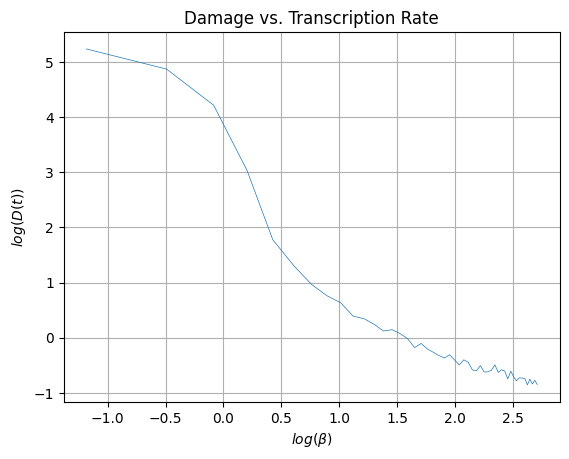

In [35]:
np.shape(average_damages)
damages = average_damages.mean(axis=1)
plt.plot(np.log(beta_vals), np.log(damages), linewidth=0.5)
plt.title('Damage vs. Transcription Rate')
plt.xlabel('$log(\\beta)$')
plt.ylabel('$log(D(t))$')
plt.grid(True)
#plt.ylabel('Average Damage over 1000 time units of 10 simulation')

# Repair Rate vs. Number of Damage Sites

In [37]:
from simulation_funcs import gillespie_draw, gillespie_ssa, simple_propensity, simple_update
import bokeh
import tqdm
import numpy as np
import bokeh.plotting as bp
from bokeh.io import show, output_notebook
from bokeh.models import Span
import matplotlib.pyplot as plt 

size = 10 # amount of simulations per run
Pd_vals = np.linspace(0, 1, 50) # beta values to test
average_damages = np.zeros((len(Pd_vals), size))

for j, Pd_val in enumerate(Pd_vals):
    # Specify parameters for calculation
    beta_mrna =  5.0 # transcription rate
    gamma_mrna = 0.1 # degradation rate
    u = 1.0 # damage accumulation rate
    Pd = Pd_val # rate of damage detection. must be between 0 and 1
    gene_on = 0.8
    gene_off = 1 - gene_on

    args = (beta_mrna, gamma_mrna, u, Pd, gene_on, gene_off)
    time_points = np.linspace(0, 500, 1001)
    population_0 = np.array([0, 0, 0, 0], dtype=int) # starting with 0 population in everything and gene OFF

    # Seed random number generator for reproducibility
    np.random.seed(42)

    # Initialize output array
    samples = np.empty((size, len(time_points), 4), dtype=int) # again, change the number here to the amount of things we are tracking

    # shape of samples is (size, time_points, amount of species)
    # size = amount of times simulation is run
    # time_points = amount of time points in each simulation
    # amount of species = how many things we are tracking, mRNA, amount of damage on gene, etc.

    # Run the calculations
    for i in tqdm.tqdm_notebook(range(size)): # to print a progress bar
        # this is storing the population at each time point for each simulation being ran (i)
        samples[i,:,:] = gillespie_ssa(simple_propensity, simple_update,
                                    population_0, time_points, args=args)
        #average_damages.append(samples[i,:,2].mean(axis=1)) # getting 
    average_damages[j] = samples[:, :, 2].mean(axis=1) # getting the average damage over every simulation


C:\Users\joeot\AppData\Local\Temp\ipykernel_12344\2957572328.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(size)): # to print a progress bar


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\joeot\AppData\Local\Temp\ipykernel_12344\2783318585.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(Pd_vals), np.log(damages), linewidth=0.5)


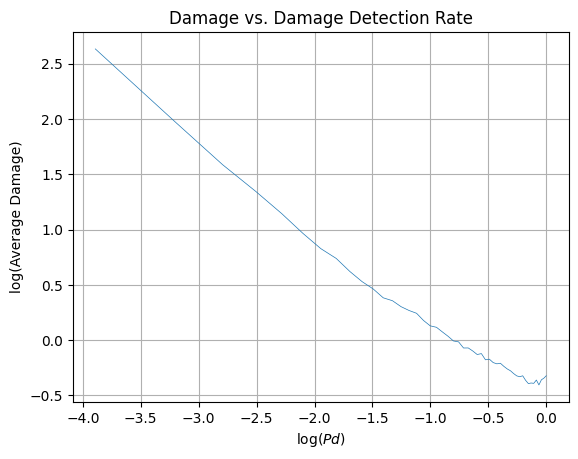

In [43]:
np.shape(average_damages)
damages = average_damages.mean(axis=1)
plt.plot(np.log(Pd_vals), np.log(damages), linewidth=0.5)
plt.title('Damage vs. Damage Detection Rate')
plt.xlabel('log($Pd$)')
plt.ylabel('log(Average Damage)')
plt.grid(True)

# Probability Distribution of D(t)

In [63]:
# Specify parameters for calculation
beta_mrna = 10.0 # transcription rate
gamma_mrna = 0.1 # degradation rate
u = 1.0 # damage accumulation rate
Pd = 0.5 # rate of damage detection. must be between 0 and 1
gene_on = 0.5
gene_off = 1 - gene_on

args = (beta_mrna, gamma_mrna, u, Pd, gene_on, gene_off)
time_points = np.linspace(0, 1000, 2001)
population_0 = np.array([0, 0, 0, 0], dtype=int) # starting with 0 population in everything and gene OFF
size = 10

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
samples = np.empty((size, len(time_points), 4), dtype=int) # again, change the number here to the amount of things we are tracking

# shape of samples is (size, time_points, amount of species)
# size = amount of times simulation is run
# time_points = amount of time points in each simulation
# amount of species = how many things we are tracking, mRNA, amount of damage on gene, etc.

# Run the calculations
for i in tqdm.tqdm_notebook(range(size)):
    # this is storing the population at each time point for each simulation being ran (i)
    samples[i,:,:] = gillespie_ssa(simple_propensity, simple_update,
                                population_0, time_points, args=args)

C:\Users\joeot\AppData\Local\Temp\ipykernel_12344\716823785.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(size)):


  0%|          | 0/10 [00:00<?, ?it/s]

(10, 2001, 4)


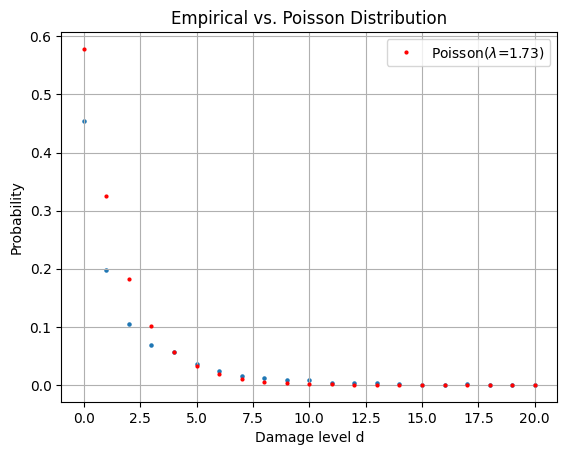

In [64]:
import matplotlib.pyplot as plt 
from numpy import random
from scipy.stats import poisson

print(np.shape(samples))
half_time = int(np.shape(samples)[1] / 2) # half the time points, i.e. from this point until the end (after we have reached a steady state)

steady_samples = samples[:, half_time:, :] # taking all samples, from the halfway point until the end

uniques = []
counts = []
totals = []

damage_values = steady_samples[:, :, 2].flatten()  # damage is column 2


unique_d, counts = np.unique(damage_values, return_counts=True)
Pr_d = counts / counts.sum()

#print(unique_d, counts)

plt.scatter(unique_d, Pr_d, s = 5)
plt.title("Damage probability distribution based on simulations")

pr_d0 = Pr_d[0] # probability of d = 0

pr_d_gt0 = 1 - pr_d0 # probability of d != 0, but it cant be negative anyway so d > 0 

# mean
mean_d = np.sum(unique_d * Pr_d) # because Pr_d is already normalised
# variance
var_d = np.sum(((unique_d - mean_d) ** 2) * Pr_d) 

from scipy.stats import poisson
from scipy.stats import expon

lambda_exp = mean_d
exp_pmf = expon.pdf(unique_d, scale=lambda_exp)

#plt.bar(unique_d, Pr_d, alpha=0.6, label="Empirical")
plt.plot(unique_d, exp_pmf, 'ro', markersize=2, label=f"Poisson($\\lambda$={lambda_exp:.2f})")
#plt.vlines(unique_d, 0, exp_pmf, colors='red', alpha=0.4)
plt.xlabel("Damage level d")
plt.ylabel("Probability")
plt.legend()
plt.title("Empirical vs. Poisson Distribution")
plt.grid(True)
plt.show()


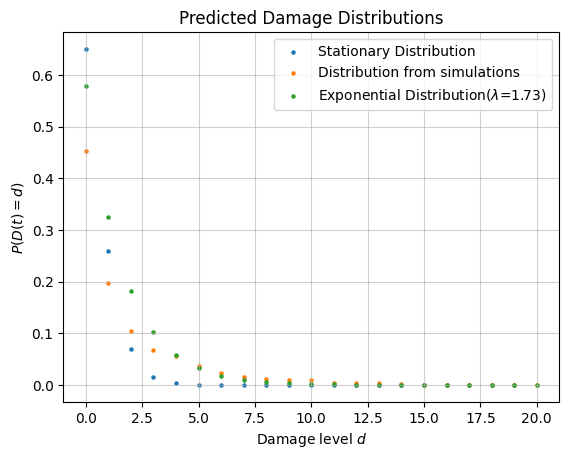

In [74]:
sum_prod = 0
sum = -1
prod = 1

for k in range(1, 1000):
    prod = 1.0
    for i in range(1, k + 1):
        prod *= u / (gene_on * beta_mrna * (1-(1-Pd)**i))
    sum_prod += prod 

pi_0 = 1 / (1 + sum_prod)

maximum_k = 20
pi_k = np.zeros(maximum_k)
pi_k[0] = pi_0
prod_k = 1
for k in range(1, maximum_k):
    prod_k = 1.0
    for i in range(1, k + 1):
        prod_k *= (u / (gene_on * beta_mrna * (1-(1-Pd)**i)))
    pi_k[k] = pi_k[0] * prod_k
pi_k = pi_k / np.sum(pi_k)

plt.scatter(range(maximum_k), pi_k, s=5, label="Stationary Distribution") 
plt.scatter(unique_d, Pr_d, s = 5, label="Distribution from simulations")
plt.scatter(unique_d, exp_pmf, s=5, label=f"Exponential Distribution($\\lambda$={lambda_exp:.2f})")
plt.legend()
plt.title('Predicted Damage Distributions')
plt.xlabel("Damage level $d$")
plt.ylabel("$P(D(t)=d)$")
plt.grid(True, alpha=0.6)

# Beta / u as they may not be distinguishable

C:\Users\joeot\AppData\Local\Temp\ipykernel_12344\2406923215.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(size)): # to print a progress bar


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

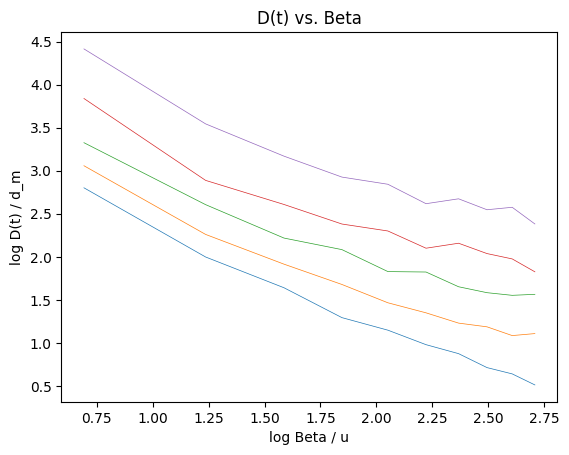

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


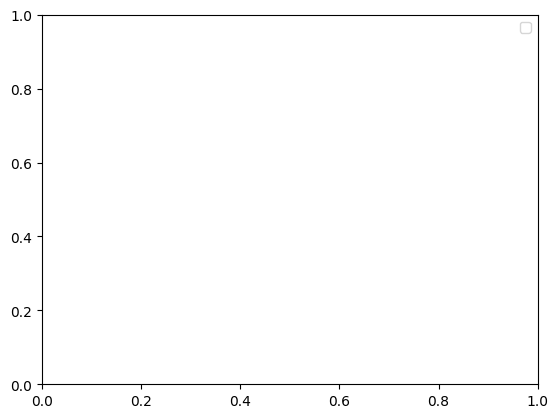

In [79]:
from simulation_funcs import gillespie_draw, gillespie_ssa, simple_propensity, simple_update
import bokeh
import tqdm
import numpy as np
import bokeh.plotting as bp
from bokeh.io import show, output_notebook
from bokeh.models import Span
import matplotlib.pyplot as plt 

# Seed random number generator for reproducibility
np.random.seed(42)

size = 10 # amount of simulations per run
beta_vals = np.linspace(2.0, 15, 10) # beta values to test # must be bigger than u
Pd_vals = np.linspace(0.1, .9, 5) # Pd values to test

#fig, axes = plt.subplots(nrows=1, ncols=len(Pd_vals), figsize=(15, 3))

for k, Pd in enumerate(Pd_vals):
    average_damages = np.zeros((len(beta_vals), size))
    for j, beta_mrna in enumerate(beta_vals):
        # Specify parameters for calculation
        beta_mrna =  beta_mrna # transcription rate
        gamma_mrna = 0.1 # degradation rate
        u = 1.0 # damage accumulation rate
        Pd = Pd # rate of damage detection. must be between 0 and 1
        gene_on = 0.8
        gene_off = 1 - gene_on

        args = (beta_mrna, gamma_mrna, u, Pd, gene_on, gene_off)
        time_points = np.linspace(0, 500, 1001)
        population_0 = np.array([0, 0, 0, 0], dtype=int) # starting with 0 population in everything and gene OFF


        # Initialize output array
        samples = np.empty((size, len(time_points), 4), dtype=int) # again, change the number here to the amount of things we are tracking

        # shape of samples is (size, time_points, amount of species)
        # size = amount of times simulation is run
        # time_points = amount of time points in each simulation
        # amount of species = how many things we are tracking, mRNA, amount of damage on gene, etc.

        # Run the calculations
        for i in tqdm.tqdm_notebook(range(size)): # to print a progress bar
            # this is storing the population at each time point for each simulation being ran (i)
            samples[i,:,:] = gillespie_ssa(simple_propensity, simple_update,
                                        population_0, time_points, args=args)
            #average_damages.append(samples[i,:,2].mean(axis=1)) # getting 
        average_damages[j] = samples[:, :, 2].mean(axis=1) # getting the average damage over every simulation

    steady_d = np.log(1-u / beta_mrna) / np.log(1-Pd)

    damages = average_damages.mean(axis=1)
    damages_dm = damages / steady_d
    beta_u = beta_vals / u
    plt.plot(np.log(beta_u), np.log(damages_dm), label=f"Pd={Pd}", linewidth=0.5)
    plt.title(f'D(t) vs. Beta')
    plt.xlabel('log Beta / u')
    plt.ylabel('log D(t) / d_m')

plt.show()
plt.tight_layout()
plt.legend()

In [ ]:
steady_d = np.log(1-u / beta_mrna) / np.log(1-Pd)

damages = average_damages.mean(axis=1)
damages_dm = damages / steady_d
beta_u = beta_vals / u
plt.plot(np.log(beta_u), np.log(damages_dm))
plt.title('Damage vs. Transcription Rate')
plt.xlabel('log Beta / u')
plt.ylabel('log D(t) / d_m')

# Testing Recurrence etc.

In [10]:
def recurrence_test(beta, Pd, u, N=1000):
    sum_mu_over_lambda = 0
    sum_lambda_over_mu = 0
    prod1 = 1
    prod2 = 1

    for i in range(1, N + 1):
        mu_i = beta * (1 - (1 - Pd)**i)
        prod1 *= mu_i / u
        prod2 *= u / mu_i

        sum_mu_over_lambda += prod1
        sum_lambda_over_mu += prod2

    return sum_mu_over_lambda, sum_lambda_over_mu
recurrence_test(beta=5.0, Pd=1.0, u=6.0, N=10000)

(5.000000000000003, inf)

In [15]:
import pandas as pd
import numpy as np

def recurrence_test(beta, Pd, u, N=1000):
    sum_mu_over_lambda = 0
    sum_lambda_over_mu = 0
    prod1 = 1
    prod2 = 1

    for i in range(1, N + 1):
        mu_i = beta * (1 - (1 - Pd)**i)
        if mu_i == 0:  # Avoid division by zero
            continue
        prod1 *= mu_i / u
        prod2 *= u / mu_i

        sum_mu_over_lambda += prod1
        sum_lambda_over_mu += prod2

    if sum_mu_over_lambda > 1e6:
        if sum_lambda_over_mu > 1e6:
            classification = 'Null recurrent'
        else:
            classification = 'Ergodic'
    else:
        classification = 'Transient'

    return sum_mu_over_lambda, sum_lambda_over_mu, classification


# Parameter ranges
betas = [0.1, 0.5, 1.0]
Pd_values = [0.1, 0.5, 0.9]
us = [0.1, 0.5, 1.0]

# Store results
results = []

for beta in betas:
    for Pd in Pd_values:
        for u in us:
            sum1, sum2, kind = recurrence_test(beta, Pd, u, N=500)
            results.append({
                'Beta': beta,
                'Pd': Pd,
                'u': u,
                'Sum μ/λ': f"{sum1:.2e}",
                'Sum λ/μ': f"{sum2:.2e}",
                'Type': kind
            })

df = pd.DataFrame(results)
df


,Beta,Pd,u,Sum μ/λ,Sum λ/μ,Type
0,0.1,0.1,0.1,1.28e-01,3.68e+08,Transient
1,0.1,0.1,0.5,2.08e-02,inf,Transient
2,0.1,0.1,1.0,1.02e-02,inf,Transient
3,0.1,0.5,0.1,1.45e+02,1.73e+03,Transient
4,0.1,0.5,0.5,1.18e-01,inf,Transient
5,0.1,0.5,1.0,5.41e-02,inf,Transient
6,0.1,0.9,0.1,4.45e+02,5.62e+02,Transient
7,0.1,0.9,0.5,2.25e-01,inf,Transient
8,0.1,0.9,1.0,9.99e-02,inf,Transient
9,0.5,0.1,0.1,inf,7.30e+00,Ergodic
